# Initial Setup

In [1]:
# Initial imports.
from typing import Tuple

import numpy as np
import pandas as pd
import sklearn.model_selection as skm
import sklearn.linear_model as skl

from functools import partial
from ISLP import load_data
from l0bnb import fit_path

from matplotlib.pyplot import subplots
from statsmodels.api import OLS
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression

from ISLP.models import ModelSpec as MS
from ISLP.models import (
    Stepwise ,
    sklearn_selected ,
    sklearn_selection_path 
)

## Laboratory: Linear Models and Regularization Methods

### Subset Selection Methods

#### Forward Selection

In [2]:
Hitters = load_data("Hitters")

np.isnan(Hitters["Salary"]).sum()

59

In [3]:
Hitters: pd.DataFrame = Hitters.dropna()

# Show it.
Hitters

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


In [4]:
def nCp(sigma2, estimator, X, Y):
    """
    Negative Cp statistic.
    """
    
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    
    return -(RSS + 2 * p * sigma2) / n

In [5]:
design = MS(Hitters.columns.drop("Salary")).fit(Hitters)

Y: np.array = np.array(Hitters["Salary"])
X: pd.DataFrame = design.transform(Hitters)

sigma2: float = OLS(Y,X).fit().scale

sigma2

99591.35617968219

In [6]:
neg_Cp = partial(nCp, sigma2)
neg_Cp?

Signature:      neg_Cp(estimator, X, Y)
Call signature: neg_Cp(*args, **kwargs)
Type:           partial
String form:    functools.partial(<function nCp at 0x7f62f0f695a0>, 99591.35617968219)
File:           /usr/lib/python3.10/functools.py
Docstring:     
partial(func, *args, **keywords) - new function with partial application
of the given arguments and keywords.

In [7]:
strategy = Stepwise.first_peak(
    model_spec=design,
    direction="forward",
    max_terms=len(design.terms)
)

In [8]:
%%time

hitters_MSE = sklearn_selected(OLS, strategy)
hitters_MSE.fit(Hitters, Y)
hitters_MSE.selected_state_

CPU times: user 3.41 s, sys: 15.2 ms, total: 3.43 s
Wall time: 3.45 s


('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

In [9]:
%%time

hitters_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
hitters_Cp.fit(Hitters, Y)
hitters_Cp.selected_state_

CPU times: user 1.89 s, sys: 809 µs, total: 1.89 s
Wall time: 1.89 s


('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

#### Choosing Among Models Using the Validation Set Approach and Cross-Validation

In [10]:
strategy = Stepwise.fixed_steps(
    design,
    len(design.terms),
    direction='forward'
)

full_path = sklearn_selection_path(OLS, strategy)
full_path

sklearn_selection_path(model_type=<class 'statsmodels.regression.linear_model.OLS'>,
                       strategy=Strategy(initial_state=(), candidate_states=<bound method Stepwise.candidate_states of <ISLP.models.strategy.Stepwise object at 0x7f62f0feba30>>, build_submodel=<bound method ModelSpec.build_submodel of ModelSpec(terms=Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'NewLeague'],
      dtype='object'))>, check_finished=functools.partial(<function fixed_steps at 0x7f62f0f43e20>, 19), postprocess=functools.partial(<function _postprocess_fixed_steps at 0x7f62f0f43f40>, 19)))

In [11]:
%%time

full_path.fit(Hitters, Y)
Yhat_in: np.ndarray = full_path.predict(Hitters)
Yhat_in.shape

CPU times: user 1.76 s, sys: 4.36 ms, total: 1.76 s
Wall time: 1.77 s


(263, 20)

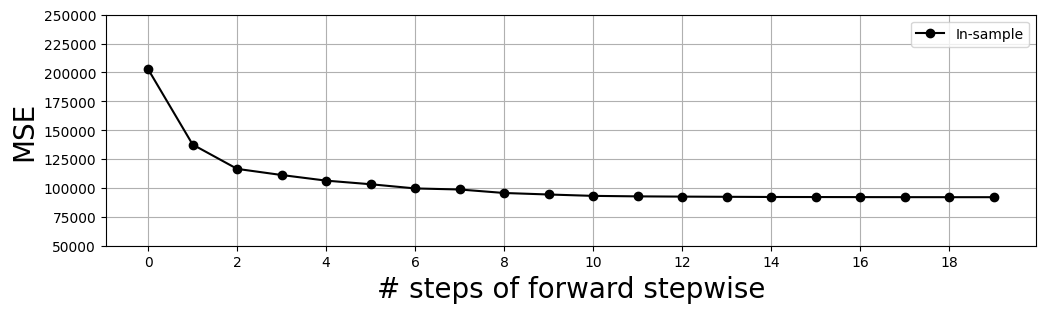

In [12]:
mse_fig, ax = subplots(figsize=(12, 3))

insample_mse: np.ndarray = ((Yhat_in - Y[:, None]) ** 2).mean(0)
n_steps: int = insample_mse.shape[0]

ax.plot(
    np.arange(n_steps),
    insample_mse,
    marker="o",
    color="k",  # color black
    label="In-sample"
)
ax.set_ylabel("MSE", fontsize=20)
ax.set_xlabel("# steps of forward stepwise", fontsize=20)
ax.set_xticks(np.arange(n_steps))
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.grid()
ax.set_ylim([50000, 250000]);

In [13]:
%%time

K: int = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)
Yhat_cv: np.ndarray = skm.cross_val_predict (full_path, Hitters, Y, cv=kfold)

Yhat_cv.shape

CPU times: user 8.79 s, sys: 35.9 ms, total: 8.82 s
Wall time: 8.95 s


(263, 20)

In [14]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):

    errors = (Yhat_cv[test_idx] - Y[test_idx, None])**2
    
    # Column means.
    cv_mse.append(errors.mean(0))  

cv_mse = np.array(cv_mse).T

cv_mse.shape

(20, 5)

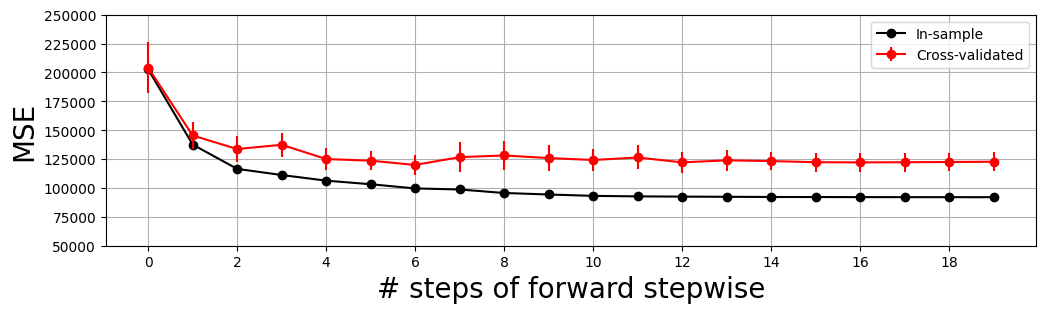

In [15]:
ax.errorbar(
    np.arange(n_steps),
    cv_mse.mean(axis=1),
    cv_mse.std(axis=1) / np.sqrt(K),
    label="Cross-validated",
    color="red",
    marker="o"
)

ax.set_ylim([50000, 250000])
ax.legend()
mse_fig

In [16]:
validation = skm.ShuffleSplit(
    n_splits=1, test_size=0.2, random_state=0
)

for train_idx, test_idx in validation.split(Y):
    
    full_path.fit(Hitters.iloc[train_idx], Y[train_idx])
    Yhat_val = full_path.predict(Hitters.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx, None])**2
    
    validation_mse = errors.mean(0)

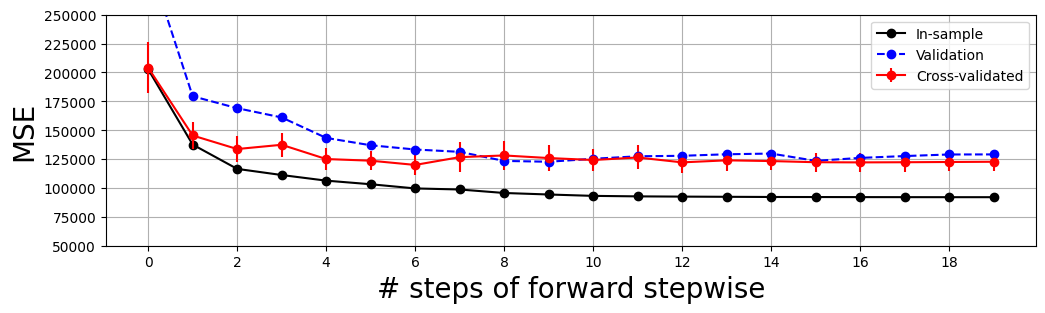

In [17]:
ax.plot(
    np.arange(n_steps), 
    validation_mse, 
    marker="o",
    color="blue",
    linestyle="--", # color blue, broken line
    label="Validation")

ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([50000, 250000])
ax.legend()
mse_fig

#### Best Subset Selection

In [18]:
D = design.fit_transform(Hitters)
D = D.drop("intercept", axis=1)
X = np.asarray(D)

X.shape

(263, 19)

In [19]:
%%time

path = fit_path(X, Y, max_nonzeros=X.shape[1])
path[3]

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19
CPU times: user 25 s, sys: 160 ms, total: 25.2 s
Wall time: 8.71 s


{'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67775265, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 'B0': -38.98216739555505,
 'lambda_0': 0.011416248027450187,
 'M': 0.5829861733382012,
 'Time_exceeded': False}

### Ridge Regression and the Lasso

## Exercises

### Conceptual

### Applied

#### 8

In [20]:
# a)

# Reprodutibility.
np.random.seed(5)

# Random predictors and noise.
X: np.ndarray = np.random.normal(loc=0.0, scale=1.0, size=(100, 1))
eps: np.ndarray = np.random.normal(loc=0.0, scale=0.1, size=(100, 1))

In [21]:
# b)

# Real parameters that generate data.
B0: float = 5.0
B1: float = -10.0
B2: float = 3.0
B3: float = 14.0

# Response.
Y: np.ndarray = B0 + B1*X + B2*(X**2) + B3*(X**3) + eps

# To dataframes.
dfY: pd.DataFrame = pd.DataFrame(Y, columns=["Y"])
dfY

,Y
0,2.453597
1,8.147095
2,199.318877
3,7.550314
4,4.008214
...,...
95,5.928728
96,8.814669
97,8.925628
98,2.569455


In [22]:
# c)

# As dataframe with intercept.
Features: np.ndarray = np.hstack([X**i for i in range(0, 11)])
dfX = pd.DataFrame(Features, columns=[f"X{i}" for i in range(0, 11)])
dfX

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,1.0,0.441227,0.194682,0.085899,0.037901,0.016723,0.007379,3.255652e-03,1.436483e-03,6.338158e-04,2.796569e-04
1,1.0,-0.330870,0.109475,-0.036222,0.011985,-0.003965,0.001312,-4.341133e-04,1.436351e-04,-4.752458e-05,1.572447e-05
2,1.0,2.430771,5.908649,14.362573,34.912128,84.863394,206.283494,5.014280e+02,1.218857e+03,2.962762e+03,7.201796e+03
3,1.0,-0.252092,0.063550,-0.016021,0.004039,-0.001018,0.000257,-6.470160e-05,1.631076e-05,-4.111815e-06,1.036556e-06
4,1.0,0.109610,0.012014,0.001317,0.000144,0.000016,0.000002,1.900846e-07,2.083514e-08,2.283736e-09,2.503200e-10
...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,0.788238,0.621319,0.489747,0.386037,0.304289,0.239852,1.890607e-01,1.490249e-01,1.174670e-01,9.259198e-02
96,1.0,-0.445430,0.198408,-0.088377,0.039366,-0.017535,0.007810,-3.479014e-03,1.549657e-03,-6.902638e-04,3.074642e-04
97,1.0,-0.482120,0.232440,-0.112064,0.054028,-0.026048,0.012558,-6.054624e-03,2.919057e-03,-1.407336e-03,6.785052e-04
98,1.0,0.493558,0.243599,0.120230,0.059341,0.029288,0.014455,7.134529e-03,3.521301e-03,1.737965e-03,8.577860e-04


In [23]:
# Model specification.
model_spec = MS(terms=dfX.columns).fit(dfX)
model_spec

ModelSpec(terms=Index(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10'], dtype='object'))

In [24]:
# Adjust a linear model with all predictors.
linear_model = OLS(endog=dfY, exog=dfX).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.874e+06
Date:                Sun, 28 Sep 2025   Prob (F-statistic):          2.58e-232
Time:                        21:22:44   Log-Likelihood:                 97.002
No. Observations:                 100   AIC:                            -172.0
Df Residuals:                      89   BIC:                            -143.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X0             5.0144      0.019    258.151      0.000       4.976       5.053
X1            -9.9422      0.058   -170.627      0.000     -10.058      -9.826
X2             2.8764      0.123     23.377      0.000       2.632       3.121
X3            13.7119      0.151     90.753      0.000      13.412      14.012
X4             0.2189      0.195      1.125      0.264      -0.168       0.605
X5             0.2650      0.110      2.407      0.018       0.046       0.484
X6            -0.1411      0.111     -1.273      0.206      -0.361       0.079
X7            -0.0702      0.028     -2.535      0.013      -0.125      -0.015
X8             0.0348      0.025      1.405      0.164      -0.014       0.084
X9             0.0050      0.002      2.480      0.015       0.001       0.009
X10           -0.0026      0.002     -1.457      0.149      -0.006       0.001
==============================================================================
Omnibus:                        0.760   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.684   Jarque-Bera (JB):                0.348
Skew:                          -0.088   Prob(JB):                        0.840
Kurtosis:                       3.229   Cond. No.                     1.10e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
# Model selection criterion scorer.
sigma2 = linear_model.scale
neg_Cp = partial(nCp , sigma2)

In [26]:
def adjust_linear_model(
        dfX: pd.DataFrame, 
        dfY: pd.DataFrame
    ) -> Tuple[OLS, float, float]:
    """
    Adjust a linear model with all predictors.
    """
    
    linear_model = OLS(endog=dfY, exog=dfX).fit()

    return linear_model, linear_model.ssr, linear_model.rsquared